## **0 - Introduction**

_In this notebook, we introduce the problem at hand, exploration our data, train classifiers, and evaluate their performance. We expect that you have followed all initial setup instructions within the README.md to run this notebook. Note that we do not perform the actual training in this notebook as it would be unreasonable to expect you to have a GPU. For this reason, we explain the training code and simply refer to the fully trained models when gauging performance._

**Set-up:**

If you are seeing this notebook for the first time and would like to run it, please follow these steps. Note that you will need several (>9) GB of free space in order to succesfully do the following:

1) In the same directory where this notebook is currently located on your device, make a new folder called "data\".
2) Visit this [page on Kaggle](https://www.kaggle.com/datasets/grassknoted/asl-alphabet) and download the dataset.
3) Extract the data from the compressed file into the "data\" folder, such that your current directory mirrors the following (thank you for helping me generate this figure ChatGPT):

```
root_directory
   |- exploratory_analysis.ipynb
   |- data
      |- asl_alphabet_test
         |- data...
      |- asl_alphabet_train
         |- data...
```

**Problem and Goal Outline:**

American Sign Language (ASL) is a sign language (SL) used by nearly half a million people in the U.S., and is primarily used by individuals within the deaf community, and those with difficulty hearing ([RI.gov](https://cdhh.ri.gov/information-referral/american-sign-language.php)). SLs are unique languages of uncertain origin with their own unique sentence structures and sets of rules, even having a wide diversity of dialects - like any language ([N.I.H.](https://www.nidcd.nih.gov/health/american-sign-language)). Unfortunately, with the lack of universality of sign languages (British sign language vs ASL for example) and the severe lack of support for SLs, access to services like healthcare can prove to be near impossible in many places ([B.U. School of Public Health](https://www.bu.edu/sph/news/articles/2018/healthcare-language-barriers-affect-deaf-people-too/)). Thus, there is a need for a greater number of tools and services for SL interpretation.

In this project, we aim to leverage machine learning classification to develop tools for aiding in interpreting the ASL alphabet, our target variable being the predicted letter. We use [Kaggle’s ASL alphabet dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet) for this purpose. This dataset consists of over 87,000 images. With 3000 images for each of the 26 letters, “delete”, “space”, and “nothing”, we hope to apply deep learning techniques for multi-class image classification. Note in the context of this problem there are no missing values. 

Additionally, we perform hand-object detection to help in applying our ASL alphabet classification model for live-inference to improve localization (by using a bounding box), and to ensure our tool’s robustness to occlusions and background noise. We work with tensorflow and models with possibly some degree of pretraining (such as VGG or ResNet) as well as a simple convolutional models. Note that we have access to several GPUs (RTX a6000, RTX a5000 on a high-performance computer, as well as an RTX 3080 on laptop). 

## **1 - Load Libraries**

In [30]:
import warnings
warnings.filterwarnings('ignore')

# Load dependencies
import math
from tensorflow.keras.utils import image_dataset_from_directory # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from sklearn.model_selection import train_test_split
import tensorflow as tf
#from tensorflow_addons.metrics import F1Score # type: ignore
import json
#from keras.layers import Conv2D, Dense, Dropout, Flatten # type: ignore
#from keras.models import Sequential # type: ignore
#from keras.models import Sequential, Model # type: ignore
from tensorflow.keras.layers.experimental.preprocessing import Rescaling # type: ignore
import numpy as np # type: ignore
from numpy.random import seed # type: ignore
#import cv2 # type: ignore
import matplotlib.pyplot as plt # type: ignore
#from tqdm import tqdm # type: ignore
#import pandas as pd # type: ignore
import random
#import tensorflow_addons as tfa # type: ignore
import os
#import sklearn
#from cv2 import imread
import numpy as np
from model.simpleModel import ConvNet3

## **2 - Setup and Preprocessing**

In [31]:
# The directory where the data is stored. Training and testing, respectively.
train_data = './data/asl_alphabet_train/asl_alphabet_train/'
test_data = './data/asl_alphabet_test/asl_alphabet_test/'

We use tensorflow's image_dataset_from_directory to take all of our data in the data folder and turn it into a Dataset object. This will permit efficient referencing of data instances through batching.

In [32]:
# Load the data into a tf.data.Dataset
batch_size = 32
img_size = (32, 32)#(64, 64)
color = 'rgb'
val_split = 0.2
random_seed = 99

class_names = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
label_map = {i: class_name for i, class_name in enumerate(class_names)} #TODO: TEST

datagen = ImageDataGenerator(rescale=1./255,
                             validation_split=val_split,
                             fill_mode='nearest')

train_dataset = datagen.flow_from_directory(train_data,
                                            target_size=img_size,
                                            color_mode=color,
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            subset='training',
                                            seed=random_seed)

val_dataset = datagen.flow_from_directory(train_data,
                                            target_size=img_size,
                                            color_mode=color,
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            subset='validation',
                                            seed=random_seed)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


## **3 - Data Exploration**

Fantastic! We now have our dataset ready to go! We will now define a few functions that will allow us to work with a and visualize our data before training.

In [33]:
def plotImages(images, labels, n_col=3, n_row=3, seed=42, color='viridis', label_map=None):
    '''
    Function to plot a grid of images. The number of columns and rows can be specified.
    '''
    # if labels are categorical:
    if len(labels.shape) > 1:
        labels = np.argmax(labels, axis=1)
        
    # Basic safety check to ensure there exist enough images in the batch. Then, get the random indices.
    if n_col * n_row > len(images):
        raise ValueError("The number of columns and rows can not be greater than the number of images.")
    indices = random.choices(range(len(images)), k= n_col * n_row)

    # Create the plot
    random.seed(seed)
    fig, axes = plt.subplots(n_row, n_col, figsize=(13, 13))
    for i in range(n_row):
        for j in range(n_col):
            axes[i, j].imshow(images[indices[i * n_col + j]], cmap=color)
            if label_map is None:
                axes[i, j].set_title(f"Label: {labels[indices[i * n_col + j]]}")
            else:
                axes[i, j].set_title(f"Label: {label_map.get(labels[indices[i * n_col + j]])}")
            axes[i, j].axis('off')
    plt.show()

Let's inspect that the images themselves are correct. It appears that there is a nice balance of images with variable lighting, position, scale (more representative data of an in real life scenario perhaps?).

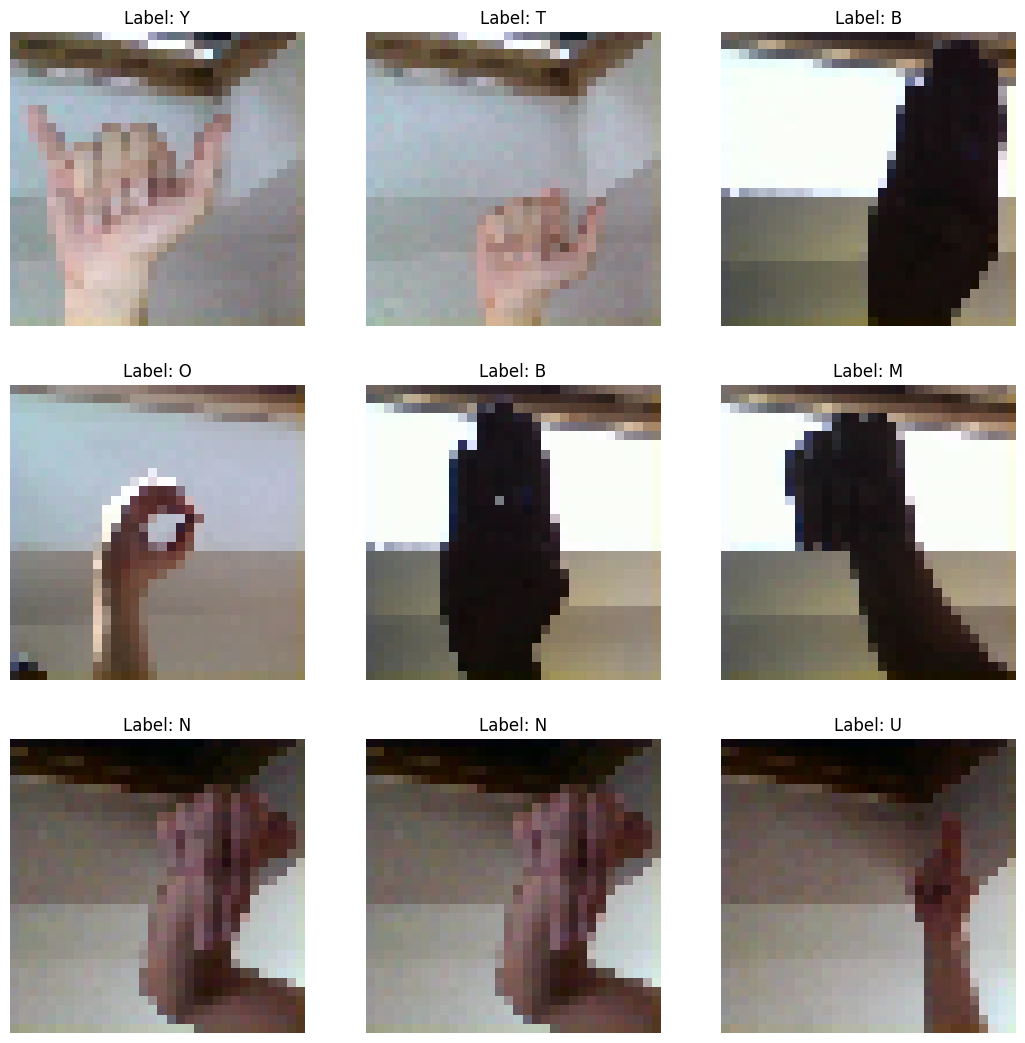

In [34]:
#batch = val_dataset.take(1)
#images, labels = next(iter(batch))

images, labels = next(train_dataset)

# Plot the images
plotImages(images, labels, n_col=3, n_row=3, color='viridis', label_map=label_map)

For this next part, we want to check the label distribution. Given that tf's Dataset has no built-in for tracking balance of labels, and due to it being inefficient to iterate over all images, we will iterate over all image directories using a custom class instead: 

In [35]:
class ASLDataPaths():
    '''
    fetchASLDataPaths is a class that fetches the paths of the ASL dataset from a directory. The rationale behind such a class
    is the fact that our dataset is huge (relatively speaking), and we can not afford to load the entire dataset of images into memory.
    Rather, it might be a better idea to load the paths of the images, and then load the images in batches as we train our model. 
    '''

    def __init__(self, data_dir: str):

        # Check if the data directory exists
        if type(data_dir) != str or not os.path.exists(data_dir):
            raise FileNotFoundError(f"The directory {data_dir} does not exist.")
        self.data_dir = data_dir

    def fetch_paths(self):
        X_paths = []
        y = []

        # Walk over the data directory and fetch the paths of all images, label in the dataset
        for root, _, files in os.walk(self.data_dir):
            for file in files:
                X_paths.append(os.path.join(root, file))
                y.append(os.path.basename(root))
        
        X_paths = np.array(X_paths)
        y = np.array(y)
        return X_paths, y

Now we can actually perform some hypothetical splittings for our data. This will not be exactly the same as how we split using the previous .take() and .skip() for the Dataset, but with the same train/val/test split proportions, it is a good enough approximation if we are not actually training on these splittings.

In [36]:
X_path, y = ASLDataPaths(data_dir = train_data).fetch_paths()
X_train_path, X_test_path, y_train, y_test = train_test_split(X_path, y, test_size=val_split, random_state=random_seed, shuffle=True)

As we can see, the distribution of labels for both the training, validation, and testing data appears uniform (something that makes clear sense if you inspect raw_data). Relatively balanced! 

What does this mean for our potential metrics? For one, have more flexibility; we could use some variation of ROC-AUC adapted for multi-class classification (one vs. all or averaging). Though, we perhaps might think about confusion matrices to understand errors at hand better and other metrics such as a precision, recall, F1 (averaged).

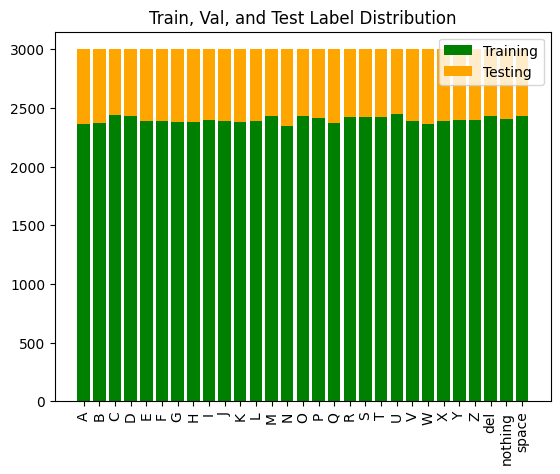

In [37]:
# Let's check how balanced the training dataset is
unique_labels_train, label_counts_train = np.unique(y_train, return_counts=True)
unique_labels_test, label_counts_test = np.unique(y_test, return_counts=True)

# Plot the distribution of the labels
plt.title('Train, Val, and Test Label Distribution')
plt.bar(unique_labels_train, label_counts_train, color='green')
plt.bar(unique_labels_test, label_counts_test, color='orange', bottom=label_counts_train)

# Other plot parameters
plt.legend(['Training', 'Testing'])
plt.xticks(rotation=90)
plt.show()

## **4 - Training**

In this section we cover the training process of our ASL hand recognition classifier. While you will not be running the actual training yourself in this notebook due to reasonable expectations for how long it should take, we will explain how the training is performed in `train.py`. Additionally, if you would like to try the training yourself, refer to the README to ensure proper setup with GPU, examples of combos of arguments, etc...

First let us start by explaining the way in which the repo is set up to perform training. In the same directory as this notebook you will find a `train.py` file. This script is set up such that you can run it from the command line, passing hyperparameters as arguments (examples which you will find in the README) using argparse. It relies on a number of other modules we wrote under `util/metric.py`, `util/model.py`, `util/directory.py`, and `util/transform.py`.

Now on to explaining whats in `train.py`:

```python
API_KEY = os.environ.get('COMET_API_KEY')

# Initialize Comet experiment
experiment = Experiment(api_key=API_KEY, 
                        project_name="asl",
                        workspace="joeshmoe03",
                        auto_output_logging="default",
                        auto_param_logging = True,
                        auto_metric_logging = True)
```

- [Comet-ml](https://www.comet.com/site/) is a platform that enables us to track metrics and training progress. This is particularly advantageous in contexts of trying to train deep learning models on remote machines with very powerful GPUs. Also, it makes nice figures for us. Here, we just initialized a new experiment to log the progress! 
- Note that we have set our API key as an environment variable for security reasons. If you would like to train, once you [sign up](https://www.comet.com/signup), you can retrieve your key and [set it as your "COMET_API_KEY" environment variable](https://www.twilio.com/en-us/blog/how-to-set-environment-variables-html) and replace "workspace" with your own.

```python

def main(args):
    ...
    # training and testing inside here
    ...
    return

if __name__ == "__main__":
    # Parser for easier running of the script on command line. Can specify hyperparameters and model type this way.  
    parser = argparse.ArgumentParser()
    parser.add_argument('-nepoch'   , type=int  , action="store", dest='nepoch'   , default=10   )
    # number of epochs
    parser.add_argument('-batchSize', type=int  , action="store", dest='batchSize', default=32   )
    # batch size
    parser.add_argument('-lr'       , type=float, action="store", dest='lr'       , default=0.001)
    # learning rate
    parser.add_argument('-resample' , type=int  , action="store", dest='resample' , default=42   )
    # resample data
    parser.add_argument('-momentum' , type=float, action="store", dest='momentum' , default=9e-06  )
    # for momentum SGD and RMSprop
    parser.add_argument('-model'    , type=str  , action="store", dest='model'    , default='resnet')
    # VGG, ResNet, etc...
    parser.add_argument('-optim'    , type=str  , action="store", dest='optim'    , default='adam')
    # SGD, adam, etc...
    parser.add_argument('-loss'     , type=str  , action="store", dest='loss'     , default='categorical_crossentropy')
    parser.add_argument('-val'      , type=float, action="store", dest='valSize'  , default=0.2  )
    # validation percentage
    parser.add_argument('-stopping' , type=int , action="store", dest='earlyStopping', default=3 )
    parser.add_argument('-color'    , type=str  , action="store", dest='color'    , default='rgb')
    # rgb, grayscale 
    parser.add_argument('-img_size' , type=int  , action="store", dest='img_size' , default=64   )
    # image size
    parser.add_argument('-data_dir' , type=str  , action="store", dest='data_dir' , default='./data/asl_alphabet_train/asl_alphabet_train/')
    parser.add_argument('-pretrain' , type=str  , action="store", dest='pretrain' , default=None)
    # use pretrained weights in specific directory
    parser.add_argument('-logits'   , type=bool , action="store", dest='from_logits', default=False) 
    # has softmax been applied for probability? If not, then set to True. See source: https://datascience.stackexchange.com/questions/73093/what-does-from-logits-true-do-in-sparsecategoricalcrossentropy-loss-function 
    parser.add_argument('-metric'   , nargs='+', type=str, action="store", dest='metric', default=['accuracy']) 
    # ['accuracy', 'precision', 'recall', 'f1_score'] NOTE: any other metric than accuracy is broken at the moment for sparse_categorical_crossentropy it appears
    parser.add_argument('-beta1'    , type=float, action="store", dest='beta1', default=0.9) 
    # for Adam optimizer. Does nothing if specified and not using Adam optimizer
    parser.add_argument('-beta2'    , type=float, action="store", dest='beta2', default=0.999) 
    # for Adam optimizer. Does nothing if specified and not using Adam optimizer
    parser.add_argument('-epsilon'  , type=float, action="store", dest='epsilon', default=1e-07) 
    # for Adam optimizer. Does nothing if specified and not using Adam optimizer
    parser.add_argument('-nest'     , type=bool, action="store", dest='nesterov', default=False) 
    # for SGD optimizer. Does nothing if specified and not using SGD optimizer
    args = parser.parse_args()
    main(args)

```

`main` represents the entry point for which we can pass a number of hyperparameters for training (`lr` for learning rate, `nepoch` for number of epochs, etc...) with [argparse](https://docs.python.org/3/library/argparse.html). We provide default arguments so that we are not required to pass everything. This is perhaps a more adaptable approach that enables us to recycle the format of our training script for future ML problems!

Inside of `main` we have:

```python
    # We save training runs and their associated sampling of data in the /temp/ 
    # directory under a folder named according to the sampling and hyperparameters.
    scratch_dir = initScratchDir(args)

    # Source: https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
    datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=args.valSize,
                                 fill_mode='nearest')

    train_dataset = datagen.flow_from_directory(args.data_dir,
                                                target_size=(args.img_size, args.img_size),
                                                color_mode=args.color,
                                                batch_size=args.batchSize,
                                                class_mode='categorical' if args.loss == 'categorical_crossentropy' else 'sparse',
                                                subset='training',
                                                seed=args.resample)

    val_dataset = datagen.flow_from_directory(args.data_dir,
                                                target_size=(args.img_size, args.img_size),
                                                color_mode=args.color,
                                                batch_size=args.batchSize,
                                                class_mode='categorical' if args.loss == 'categorical_crossentropy' else 'sparse',
                                                subset='validation',
                                                seed=args.resample)
```

Here we use a function under `util/directory.py` to initialize a directory named according to the training run hyperparameters, where we save the outcome of our training process. This allows us to compare models and metrics after the fact for greater reproducibility!

1) We use an ImageGenerator as it matches the file structure of our dataset. We simply pass the hyperparameters that specify how we want the data to look for training. Note that we don't naively load the entirety of the dataset into memory all at once, as it is nearly 9-10 GB in size - too much! Instead we rely on the specification of a `arg.batchSize` to make more realistic usage of memory.
2) We also encode labels on the basis of loss functions. Loss functions like `"sparse_categorical_crossentropy"` may require a single column of labels whereas `"categorical_crossentropy"` requires one-hot encoding. For our particular task of multiclass classification, we need a loss function to calculate cross entropy between a probabilities of a predicted class and a target such that the sample falls in only one of several categories. It is computed as the negative sum over classes of targets * the log of the outputted probability. 
3) We then perform the splittings based on the specified arguments or defaults. 
4) We apply our firest set of transformations. Our set of transformations on the training data is distinct from those applied to the validation and testing data.

```python
    with tf.device('/device:gpu:0'):
        # Load the model and optimizer and loss functions
        model = ModelFactory(args, args.model).fetch_model(args, num_classes=29)
        # Supported optimizers are SGD and Adam
        optimizer = optimizerFactory(args)
        # Supported loss functions are categorical_crossentropy and sparse_categorical_crossentropy
        loss = lossFactory(args)
        # Supported metrics are precision, recall, average, and macro-averaged f1 score
        metrics = metricFactory(args, num_classes = 29)
        # Compile the model: https://stackoverflow.com/questions/59353009/list-of-metrics-that-can-be-passed-to-tf-keras-model-compile 
        model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
        # Callbacks for saving the model. Early stopping can be added if specified to the command line to prevent overfitting (callbacks)
        callbacks = checkpointProgress(scratch_dir, args, experiment)
```

5) We try to use a gpu for quicker training time.
6) We call ModelFactory (`util/model.py`) to retrieve the correct model and associated weights based on the arguments passed to the CLI.
7) We do the same for selecting the optimizer (and passing along the right argument to that optimizer - from_logits).
8) We do the same for the optimizer with the correct hyperparameters passed in args.
9) We do the same for metrics (`util/metric.py`) where we pass which metrics we care to track. By default, we pass `[accuracy, precision, recall, F1]`. These are averages for the latter metrics where F1 is calculated as a macro-average (no regard for weight of each class).
10) We compile the model with optimizer, loss, and metric in mind.
11) We specify callbacks (`util/directory.py`). These enable us to specify when to interrupt the training progress temporarily when saving the current model with minimum validation loss, performing early stopping if specified in arguments (see README) and loss is not improving, or simply logging metrics with comet-ml.

```python
        with experiment.train():
            train_history = model.fit(train_dataset, validation_data = val_dataset, epochs = args.nepoch, callbacks = callbacks)

        with experiment.test():
            test_history = model.evaluate(test_dataset, batch_size=args.batchSize)
        
        # Save the history of the training run and testing run.
        json.dump(train_history.history, open(os.path.join(scratch_dir, 'trainhistory.json'), 'w')) 
        json.dump(test_history, open(os.path.join(scratch_dir, 'testhistory.json'), 'w'))
```

12) In this last phase, we finally perform the training to fit our model, and evaluate on our testing data when we are done. 
13) We dump all of this history in json files so that we can revisit them later. Note that also during this entire process, comet-ml is also tracking the metrics and making some nice figures!

## **5 - Findings**

In [38]:
from model.simpleModel import ConvNet3
from model.vgg import Vgg16

# Create an instance of your class-based model
#model = ConvNet3(num_classes=29, input_shape=(64, 64, 3))
model = Vgg16(32, 'rgb', num_classes=29)

# Debugged building: https://stackoverflow.com/questions/59356410/tensorflow-2-0-build-function
# for an explanation of why you need to call .build() before loading weights.
model.build((None, 64, 64, 3))

# Display the model summary to show the architecture
model.summary()

convnet3 = os.path.join('temp', 'convnet3_adam_categorical_crossentropy_lr0.001_mo9e-06_rs9964', 'convnet3.h5')
vgg = os.path.join('temp', 'vgg_adam_categorical_crossentropy_lr0.001_mo9e-06_rs9932', 'vgg.h5')

# Load the weights into the model
model.load_weights(vgg)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 29)                14877     
                                                                 
Total params: 14,992,221
Trainable params: 14,992,221
Non-trainable params: 0
_________________________________________________________________


In [39]:
from sklearn.metrics import confusion_matrix


# Accumulate true labels and predicted labels
y_true = []
y_pred = []

# Number of batches to test: FEEEL FREE TO CHANGE THIS
num_batches_to_test = 100

# Loop over the validation dataset 
for i in range(num_batches_to_test):
    # Get the next batch of images and labels
    images, labels = next(val_dataset)

    # Make predictions
    prediction = model.predict(images)
    
    # Get the index of the highest probability
    predicted_class = np.argmax(prediction, axis=1)
    
    # Accumulate true and predicted labels
    y_true.append(np.argmax(labels, axis=1))
    y_pred.append(predicted_class)

# Convert lists to numpy arrays
y_true = np.concatenate(y_true)

# smoosh 2d into 1d
y_pred = np.array(y_pred).flatten()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

1/1 [==============================] - 0s 16ms/step


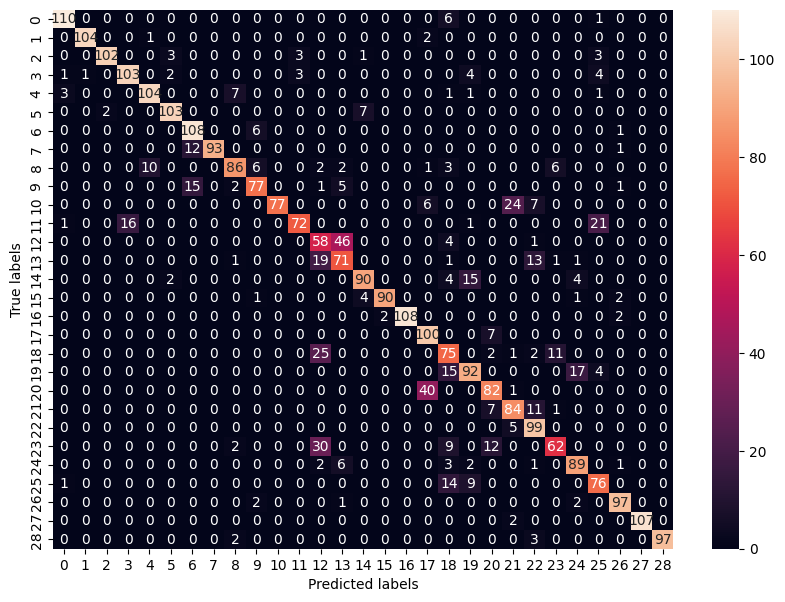

In [40]:
# print confusion matrix in more readable format
import seaborn as sns
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

1/1 [==============================] - 0s 20ms/step
Top 3 classes: ['F', 'O', 'C', 'P', 'D']
Predicted class: 5 with probability 0.9894
Actual class: 5 with probability 0.9894


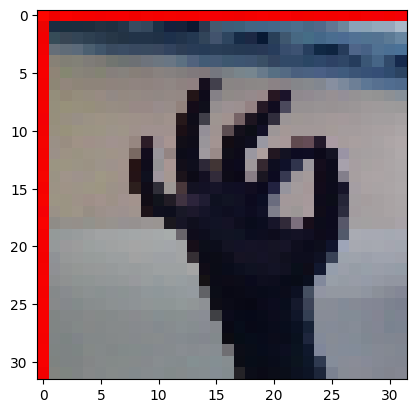

In [48]:
import cv2
letter = 'F'

# retrieve the label
label = class_names.index(letter)

test_img = cv2.imread(f'data/asl_alphabet_test/asl_alphabet_test/{letter}_test.jpg')

# resize the image and preprocess it
test_img = cv2.resize(test_img, img_size, interpolation=cv2.INTER_NEAREST)

# rescale
test_img = test_img / 255.0

#test_img = tf.image.convert_image_dtype(test_img, tf.float32)
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)
predicted_class = np.argmax(prediction)

# top 3 predictions
top_3 = np.argsort(prediction[0])[-5:][::-1]
print(f"Top 3 classes: {[label_map.get(i) for i in top_3]}")
print(f"Predicted class: {predicted_class} with probability {str(round(prediction[0][predicted_class], ndigits=4))}")
print(f"Actual class: {label} with probability {str(round(prediction[0][label], ndigits=4))}")

# plot the image
plt.imshow(test_img.squeeze())